### **Imports**

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Create model**

In [ ]:
## Modifiable variables
input_shape = (200,200,3) ##based on our images 200x200x3
epochs = 25 ##can increase as needed -- tradeoff with size
batch_size = 128 ## can decrease as needed -- tradeoff with size
number_of_test_images = 2000;
number_of_train_images = 10000;

CorrectLabels = [];
for i in range(0, 1000):
  CorrectLabels.append(0); ##cats
for i in range(0, 1000):
  CorrectLabels.append(1); ##dogs

## Load pretrained VGG16
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

## These layers were already trained. Do not train them again
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

# Specify networks output    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
## Flatten the output layer to one dimension
x = tf.keras.layers.GlobalMaxPool2D()(last_output)

## Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

## Add a dropout rate of 0.5
x = Dropout(0.5)(x)

## Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

## Define & compile our model
our_vgg = tf.keras.Model(pre_trained_model.input, x)
our_vgg.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), metrics=['accuracy'])

### **Train model**

In [ ]:
train = train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
test = ImageDataGenerator(rescale=1./255)

# prepare iterators
train_it = train.flow_from_directory("./drive/Shareddrives/EECS 351 Project/half_cats_and_dogs/train" , shuffle=True, class_mode='binary', batch_size=batch_size, target_size=(200, 200))
test_it = test.flow_from_directory("./drive/Shareddrives/EECS 351 Project/half_cats_and_dogs/validation", shuffle=False, class_mode='binary', batch_size=batch_size, target_size=(200, 200))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
## Variables to prevent overfitting
earlystop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, mode='auto') ##early stop = stop model learning after 10 epochs when val_loss value not decreased.
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001) ##reduce the learning rate when accuracy, for example, not increase for two continuous steps.
callbacks = [earlystop, learning_rate_reduction] ##combine as callbacks to pass into fit function

## Train on our data. This step takes time, be patient! Progress will be printed.
history = our_vgg.fit(train_it, epochs=epochs,validation_data=test_it,validation_steps=number_of_test_images//batch_size, steps_per_epoch=number_of_train_images//batch_size, callbacks=callbacks)

Epoch 1/25
78/78 [==============================] - 148s 2s/step - loss: 0.7038 - accuracy: 0.5850 - val_loss: 0.5182 - val_accuracy: 0.8135 - lr: 1.0000e-04
Epoch 2/25
78/78 [==============================] - 132s 2s/step - loss: 0.5491 - accuracy: 0.7092 - val_loss: 0.3902 - val_accuracy: 0.8771 - lr: 1.0000e-04
Epoch 3/25
78/78 [==============================] - 133s 2s/step - loss: 0.4437 - accuracy: 0.7933 - val_loss: 0.3107 - val_accuracy: 0.8911 - lr: 1.0000e-04
Epoch 4/25
78/78 [==============================] - 132s 2s/step - loss: 0.3648 - accuracy: 0.8391 - val_loss: 0.2645 - val_accuracy: 0.9005 - lr: 1.0000e-04
Epoch 5/25
78/78 [==============================] - 133s 2s/step - loss: 0.3224 - accuracy: 0.8603 - val_loss: 0.2394 - val_accuracy: 0.9115 - lr: 1.0000e-04
Epoch 6/25
78/78 [==============================] - 134s 2s/step - loss: 0.2845 - accuracy: 0.8820 - val_loss: 0.2294 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 7/25
78/78 [==============================] - 

### **Test model**

In [ ]:
# evaluate model and print accuracy & loss
loss, accuracy = our_vgg.evaluate(test_it, steps=len(test_it), verbose=0)
print('Test loss: > %.3f' % (loss * 100.0))
print('Test accuracy: > %.3f' % (accuracy * 100.0))

Test loss: > 14.901
Test accuracy: > 94.050


### **Create Graphs**

In [ ]:
# make confusion matrix
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

predicted_labels = our_vgg.predict(test_it);

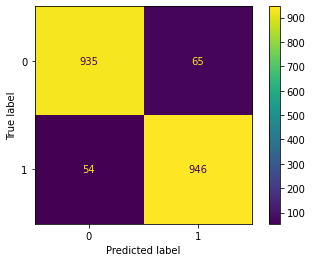

In [ ]:
# convert predicted labels from probabilities to binary values
binaryPredictedLabels = []
probaPredictedLabels = predicted_labels.tolist()
for test_sample_label in probaPredictedLabels:
  if test_sample_label[0] < 0.5:
    binaryPredictedLabels.append(0)
  else:
    binaryPredictedLabels.append(1)

cm = confusion_matrix(CorrectLabels, binaryPredictedLabels)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

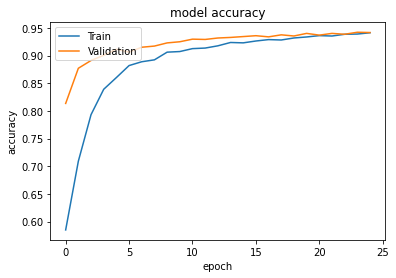

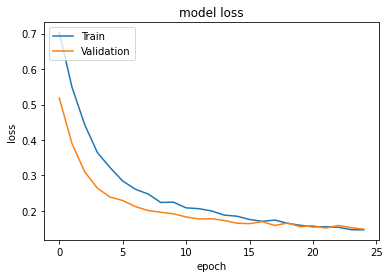

In [ ]:
##plot losses & accuracy over epochs
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()